In [1]:
# !pip install SimpleITK==2.0.2
import SimpleITK as sitk
from skimage import measure
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from function import lungmask, write_sitk_from_array_by_template
import pandas as pd

img_dir = 'image_in_nifty/'
mask_dir = 'mask_in_nifty/'
roi_dir = 'segmented_lung_in_nifty/'
csv_write_path = 'lung_vessel_volume.csv'
df_init = pd.DataFrame()

for idx, d in enumerate(sorted(os.listdir(img_dir))):
    
    if 'nii.gz' in d :
        print('processing：', img_dir + d)
        try:
            T1 = time.perf_counter()
            img_path = img_dir + d
            vol_sitk = sitk.ReadImage(img_path)  
            volarray = sitk.GetArrayFromImage(vol_sitk)
            vol_size = volarray.shape
            
            # indivudualize the seed_list and threshold value for the seed filling algorithim
            # 05,06 has the different parameters than the remainning ones
            seed_list = [(0,0,0),(vol_size[0]-1,vol_size[1]-1,0),(487,424,0)] 
            t_value = -300            
            if '05' in d :
                seed_list =[(0,0,0),(vol_size[0]-1,vol_size[1]-1,0)]
                t_value = -800             
            if '06' in d :
                seed_list = [(0,0,0),(vol_size[0]-1,vol_size[1]-1,0),(483,474,0)]
                t_value = -600                               
            mask_array = lungmask(vol_sitk,t_value,seed_list)
            
            # write the mask into the mask_path
            # write the segmented lung into the roi_path
            mask_path = mask_dir + d.replace('.nii.gz','_mask.nii.gz')
            roi_path = roi_dir + d.replace('.nii.gz','_lung_roi.nii.gz')
            write_sitk_from_array_by_template(mask_array,vol_sitk,mask_path)
            lung_array = volarray * mask_array
            lung_array [lung_array==0] = -1024          
            write_sitk_from_array_by_template(lung_array,vol_sitk,roi_path)
            
            # compute the lung, vessel volume and its ration, write into a csv file
            lung_volume = np.sum(mask_array) * vol_sitk.GetSpacing()[0]\
                                    * vol_sitk.GetSpacing()[1] * vol_sitk.GetSpacing()[2] / 1000
            vessle_array = np.copy(lung_array)
            vessle_array[vessle_array>=-500] = 1
            vessle_array[vessle_array<=-500] = 0
            vessle_volume = np.sum(vessle_array) * vol_sitk.GetSpacing()[0]\
                                    * vol_sitk.GetSpacing()[1] * vol_sitk.GetSpacing()[2] / 1000 
            vessel_lung_ratio = vessle_volume / lung_volume
            
            df_inter = pd.DataFrame({'CT_id': d,
                       'lung_volume':round(lung_volume,3),
                       'vessle_volume':round(vessle_volume,3),
                       'vessel_lung_ratio':round(vessel_lung_ratio,5)},index=[0])
            
            df_init = pd.concat([df_init, df_inter])
            df_init.to_csv(csv_write_path)
            print(idx,'th',d,'lung_volume',round(lung_volume,3),'vessle_volume',round(vessle_volume,3))        
            print('segmented mask is wrote into: ', mask_path,'\n')           
        except Exception as e:
            print("ERROR : "+str(e))

processing： image_in_nifty/vol_01.nii.gz
0 th vol_01.nii.gz lung_volume 475.129 vessle_volume 25.305
segmented mask is wrote into:  mask_in_nifty/vol_01_mask.nii.gz 

processing： image_in_nifty/vol_02.nii.gz
1 th vol_02.nii.gz lung_volume 566.587 vessle_volume 18.505
segmented mask is wrote into:  mask_in_nifty/vol_02_mask.nii.gz 

processing： image_in_nifty/vol_03.nii.gz
2 th vol_03.nii.gz lung_volume 410.524 vessle_volume 19.918
segmented mask is wrote into:  mask_in_nifty/vol_03_mask.nii.gz 

processing： image_in_nifty/vol_04.nii.gz
3 th vol_04.nii.gz lung_volume 633.957 vessle_volume 34.598
segmented mask is wrote into:  mask_in_nifty/vol_04_mask.nii.gz 

processing： image_in_nifty/vol_05.nii.gz
4 th vol_05.nii.gz lung_volume 532.907 vessle_volume 66.767
segmented mask is wrote into:  mask_in_nifty/vol_05_mask.nii.gz 

processing： image_in_nifty/vol_06.nii.gz
5 th vol_06.nii.gz lung_volume 353.86 vessle_volume 13.667
segmented mask is wrote into:  mask_in_nifty/vol_06_mask.nii.gz 


1 th vol_01_lung_roi.nii.gz


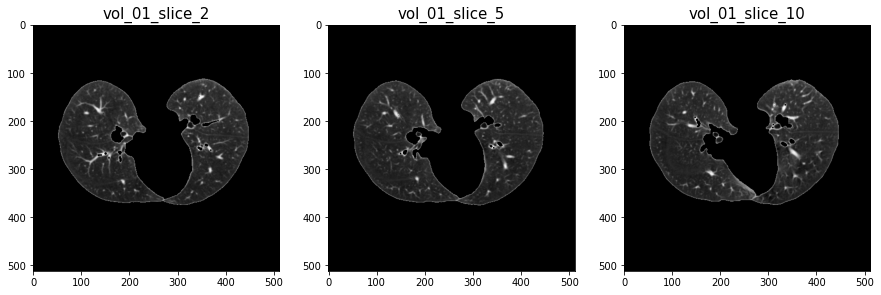

2 th vol_02_lung_roi.nii.gz


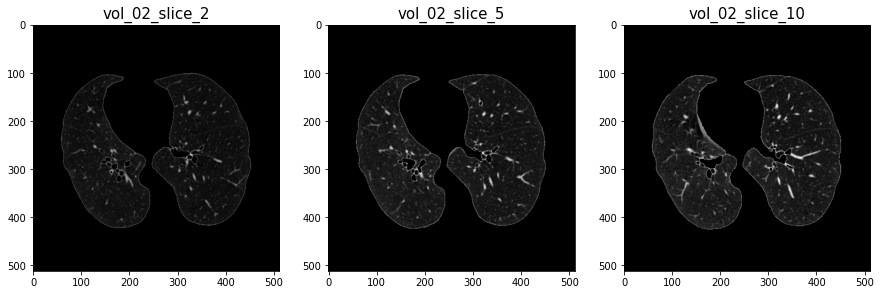

3 th vol_03_lung_roi.nii.gz


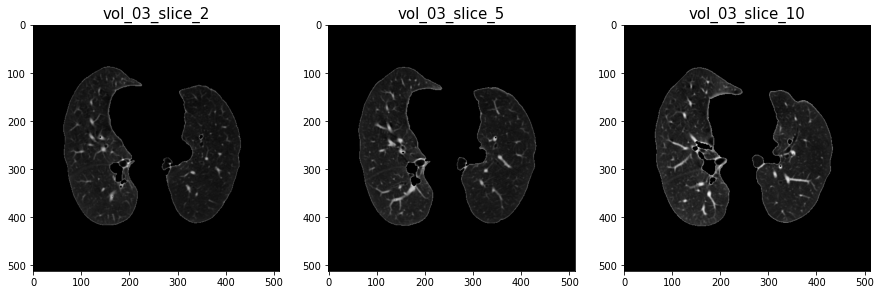

4 th vol_04_lung_roi.nii.gz


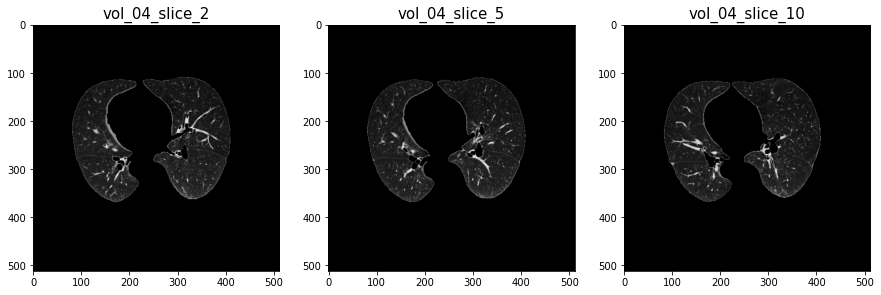

5 th vol_05_lung_roi.nii.gz


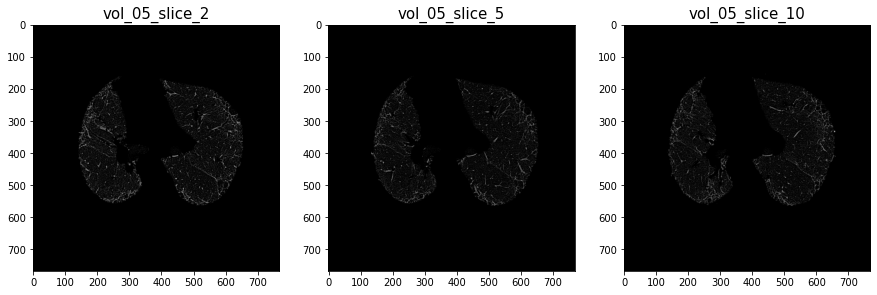

6 th vol_06_lung_roi.nii.gz


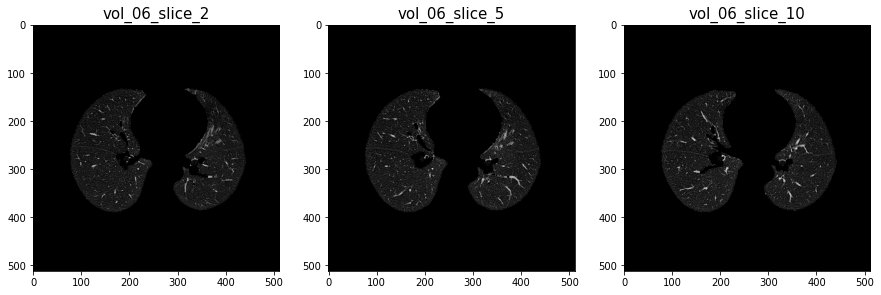

7 th vol_07_lung_roi.nii.gz


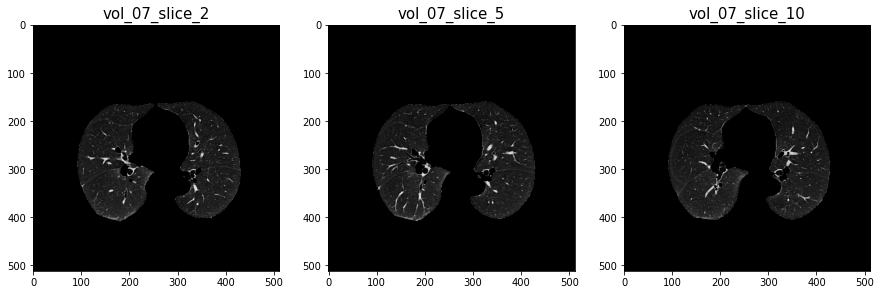

8 th vol_08_lung_roi.nii.gz


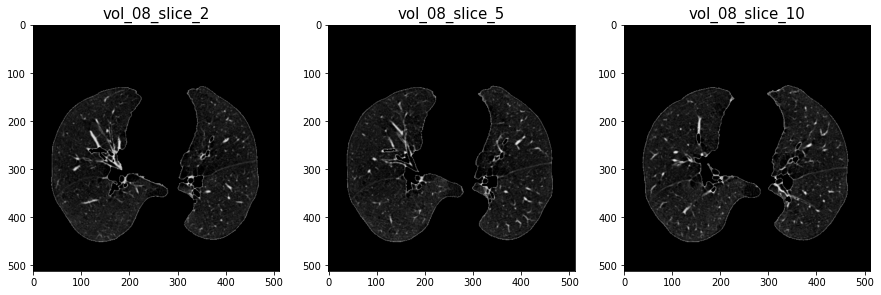

9 th vol_09_lung_roi.nii.gz


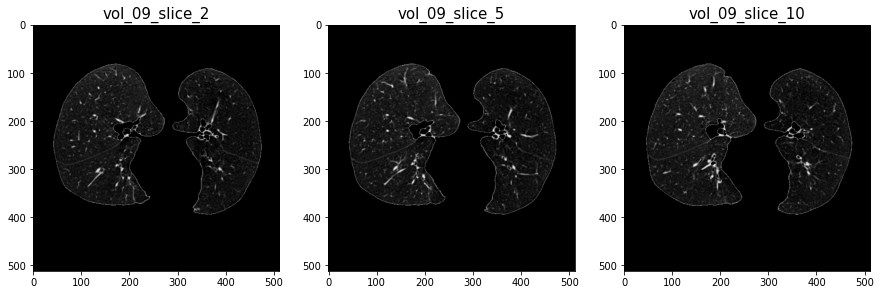

In [4]:
# check out the segment output by plt
roi_dir = 'segmented_lung_in_nifty/'

for idx, d in enumerate(sorted(os.listdir(roi_dir))):
    
    if 'nii.gz' in d :        
        img_path = roi_dir + d
        vol_sitk = sitk.ReadImage(img_path)  
        volarray = sitk.GetArrayFromImage(vol_sitk)
        array_show = np.copy(volarray)
        
        print(idx+1,'th',d)
        fig, ax = plt.subplots(1,3,figsize=(15, 15))
        ax[0].imshow(array_show[2, :, :], cmap = 'gray')
        ax[0].set_title(d[:6]+'_slice_2', fontsize = 15)
        ax[1].imshow(array_show[5, :, :], cmap = 'gray')
        ax[1].set_title(d[:6]+'_slice_5', fontsize = 15)
        ax[2].imshow(array_show[10, :, :], cmap = plt.cm.gray)
        ax[2].set_title(d[:6]+'_slice_10', fontsize = 15)
        plt.show()